## Which TESS candidates should I target?
Use this notebook to filter a list of TESS Objects of Interst (TOI) for visibility at a specific site and time and for effective temperature. This template checks for visibility from the Calar Alto Observatory (CAHA) in Spain, but it is easy to adapt to a different use case.

#### Minimum Working Instructions:
- download a CSV file containing TESS alerts (from tev.mit.edu) and save it in `data/`
- Adjust the parameters (see below) to your needs
- execute the cells in this notebook 

In [23]:
import astroplan
import numpy as np
import datetime as dt
from astroquery.mast import Catalogs
from astroplan.plots import plot_airmass
from observability import *
from IPython.core.display import display, HTML

apply some convenient ipython magic

In [24]:
%load_ext autoreload
%autoreload 2

display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.max_columns', 500)
pd.set_option('precision',2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Specify Parameters
Define observational constraints, the Calar Alto Observatory, a maximum effective temperature.

In [68]:
alertsFile = 'data/csv-file-toi-catalog.csv'    # path to the alerts file
lastUpdate = '2020-02-23'                 # include only alerts added after this date
earliestObs = str(np.datetime64('today')) # earliest time we are interested in for observations
latestObs = '2020-09-30 12:00'            # latest time we are interested in for observations
minAltitude = 30                          # minimum elevation for visibility [deg]
Teff_max = 4000                           # maximum temperature for the M-dwarf-filter [K]
CAHA = defineCAHA()                       # define observing location, in this case Calar Alto observatory

### Read alerts
Specify minimum time in column "Updated" (=last time we checked)

In [32]:
# alerts, targets = targetsFromCSV(alertsFile, minUpdated=lastUpdate)
alerts, targets = targetsFromCSV(alertsFile, minUpdated=lastUpdate, header=4)
alerts.head()
print(len(alerts))

36


### Define Observing Constraints

In [33]:
constraints, start_time, end_time = define_constraints(minAltitude, earliestObs, latestObs)

### Check Observability from CAHA Given the Constraints

In [41]:
# The IERS server was down. Increase auto-download max age parameter
from astropy.utils import iers
iers.conf.auto_max_age = 60.

In [42]:
%%time
observables = check_observability(alerts, constraints, CAHA, targets, Time(earliestObs),
                                 Time(latestObs))
print(len(observables))

33
CPU times: user 18.3 ms, sys: 4.59 ms, total: 22.9 ms
Wall time: 22.5 ms


### Filter for M dwarf Spectral Type

Query TIC on MAST with observable objects, simultaneously filtering by effective temperature

In [43]:
%%time
observableMdwarfs = Catalogs.query_criteria(catalog="Tic",Teff=[0,Teff_max], ID=observables.TIC).to_pandas()
observableMdwarfs

CPU times: user 246 ms, sys: 11.6 ms, total: 258 ms
Wall time: 1.52 s


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1271: TableReplaceWarning: converted column 'HIP' from integer to float
  exec(code, glob, local_ns)
/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1271: TableReplaceWarning: converted column 'KIC' from integer to float
  exec(code, glob, local_ns)


### Output
Display the information we need in a convenient way and produce plots that facilitate target selection.

Merge the two tables

In [44]:
observableMdwarfs.rename(columns={'ID' : 'TIC'}, inplace=True)
observableMdwarfs.TIC = observableMdwarfs.TIC.astype('int64')
observableMdwarfs = pd.merge(observables, observableMdwarfs, on='TIC', how='inner')
candidateTargets = [t for t in targets if float(t.name) in observableMdwarfs['Full TOI ID'].unique()]
observableMdwarfs

,TIC,Full TOI ID,Group Disposition,TOI Disposition,EXOFOP Disposition,TIC Right Ascension,TIC Declination,TMag Value,TMag Uncertainty,Orbital Epoch Value,Orbital Epoch Error,Orbital Period Value,Orbital Period Error,Transit Duration Value,Transit Duration Error,Transit Depth Value,Transit Depth Error,Sectors,Public Comment,Updated,Edited,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,objType,typeSrc,ra,dec,POSflag,pmRA,e_pmRA,pmDEC,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,Tmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID
0,104208182,1738.01,PC,PC,NaN,54.50,50.96,12.49,7.26e-03,1792.66,2.78e-03,3.70,4.10e-04,1.42,0.64,2875.24,330.67,18 19,Possible odd-even,2020-02-27 22:12:18,2020-02-27 22:21:25+0000,20190415,NaN,NaN,705-026143,03380047+5057197,NaN,J033800.50+505718.8,442083492038286336,56550789,NaN,STAR,tmgaia2,54.50,50.96,tmgaia2,26.65,0.05,-86.19,0.04,gaia2,7.01,0.02,gaia2,147.73,-3.72,64.86,30.57,15.46,0.02,14.07,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.31,0.02,10.61,0.02,10.46,0.01,AAA-222-111-000-0-0,NaN,10.38,0.02,10.44,0.02,10.37,0.07,9.00,NaN,13.41,2.61e-04,12.49,7.26e-03,cdwrf,cdwrf,3948.0,157.0,4.59,1.18e-02,NaN,NaN,0.67,1.96e-02,0.64,0.02,2.14,0.12,DWARF,9.80e-02,2.14e-02,142.04,0.50,9.00e-02,NaN,278,3.90e-02,NaN,NaN,7.89e-04,NaN,NaN,schlegel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bj2018,NaN,NaN,cdwrf,14.31,1.77e-03,12.49,8.18e-04,1,NaN,cdwrf,apassdr9,cooldwarfs_v8,0.83,0.58,54.50,50.96,0.02,0.01,1,0,49169511
1,219860288,1743.01,PC,PC,NaN,257.75,71.87,12.43,7.42e-03,1713.43,1.32e-03,4.27,8.40e-05,0.75,0.45,2478.34,280.51,15 16 17 18 19,v-shaped,2020-02-27 22:12:18,2020-02-27 22:21:25+0000,20190415,NaN,NaN,810-024138,17105910+7152170,1237656563283460119,J171059.28+715218.9,1651807592698185728,60084602,NaN,STAR,tmgaia2,257.75,71.87,tmgaia2,66.98,0.09,188.77,0.09,gaia2,24.20,0.05,gaia2,103.20,33.43,123.69,83.16,16.68,0.12,14.97,0.07,18.49,1.92e-02,15.87,4.74e-03,14.57,7.60e-03,12.97,3.47e-03,12.15,5.10e-03,10.81,0.02,10.25,0.02,10.00,0.01,AAA-222-111-000-0-0,NaN,9.84,0.02,9.66,0.02,9.52,0.03,9.58,0.43,13.73,8.90e-04,12.43,7.42e-03,cdwrf,cdwrf,3281.0,157.0,4.90,3.62e-03,NaN,NaN,0.32,9.42e-03,0.30,0.02,9.14,0.19,DWARF,1.07e-02,2.69e-03,41.28,0.09,0.00e+00,0.00e+00,68,8.72e-03,NaN,NaN,9.98e-03,0.00e+00,0.00e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bj2018,NaN,NaN,cdwrf,15.30,2.71e-03,12.51,1.80e-03,1,NaN,cdwrf,apassdr9,cooldwarfs_v8,1.68,1.35,257.75,71.87,0.05,0.05,1,0,167344109
2,232635922,1745.01,PC,PC,NaN,281.14,54.95,12.80,7.52e-03,1683.92,2.56e-03,5.99,1.70e-04,1.57,0.41,2722.24,281.75,14 15 16 18 19,Could be stellar variability,2020-02-27 22:12:18,2020-02-27 22:21:25+0000,20190415,NaN,NaN,725-058831,18443291+5457004,NaN,J184432.77+545659.8,2147696132919579904,56291060,NaN,STAR,tmgaia2,281.14,54.95,tmgaia2,-114.19,0.09,-49.26,0.10,gaia2,11.87,0.05,gaia2,84.40,22.87,300.10,77.22,16.14,0.04,14.52,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.52,0.02,10.92,0.02,10.76,0.02,AAA-222-111-000-0-0,NaN,10.62,0.02,10.50,0.02,10.43,0.05,9.40,NaN,13.84,1.23e-03,12.80,7.52e-03,cdwrf,cdwrf,3759.0,157.0,4.80,4.79e-03,NaN,NaN,0.42,1.26e-02,0.42,0.02,5.48,0.22,DWARF,3.24e-02,7.37e-03,84.03,0.34,0.00e+00,0.00e+00,138,8.48e-02,NaN,NaN,4.25e-03,0.00e+00,0.00e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.33,0.34,bj2018

Display columns relevant for candidates spreadsheet

In [66]:
to_spreadsheet = observableMdwarfs[['TIC', 'Full TOI ID', 'GAIA', 'TIC Right Ascension', 'TIC Declination', 'rad', 'mass', 'logg', 'Teff', 'gmag', 'Jmag', 'Hmag', 'Kmag']]
to_spreadsheet.to_excel('data/newCandidates.xls', float_format="%.20f")
to_spreadsheet

,TIC,Full TOI ID,GAIA,TIC Right Ascension,TIC Declination,rad,mass,logg,Teff,gmag,Jmag,Hmag,Kmag
0,104208182,1738.01,442083492038286336,54.50,50.96,0.67,0.64,4.59,3948.0,NaN,11.31,10.61,10.46
1,219860288,1743.01,1651807592698185728,257.75,71.87,0.32,0.30,4.90,3281.0,15.87,10.81,10.25,10.00
2,232635922,1745.01,2147696132919579904,281.14,54.95,0.42,0.42,4.80,3759.0,NaN,11.52,10.92,10.76
3,232650365,1746.01,2146945029037813760,281.77,54.91,0.41,0.40,4.82,3340.0,NaN,10.28,9.72,9.50
4,233602827,1749.01,2253774094189458432,282.74,64.42,0.56,0.56,4.68,3959.0,15.93,11.07,10.45,10.27
5,233602827,1749.02,2253774094189458432,282.74,64.42,0.56,0.56,4.68,3959.0,15.93,11.07,10.45,10.27
6,287139872,1752.01,1438168463332034816,253.46,60.71,0.53,0.52,4.71,3652.0,NaN,11.37,10.78,10.54
7,332477926,1754.01,1422202558064520576,265.59,57.45,0.59,0.58,4.66,3849.0,15.12,10.48,9.81,9.66
8,364074068,1756.01,2290553720211705344,306.33,77.64,0.56,0.56,4.68,3756.0,15.59,10.81,10.13,9.96
9,408636441,1759.01,2216420110788943744,326.85,62.75,0.63,0.61,4.63,3960.0,NaN,8.77,8.11,7.93


## Update shared spreadsheet

In [75]:
import gdoc
import credentials # local file including sheet ID (part of its URL) and range_name

sheet = gdoc.read_sheet(sheet_ID, range_name)

HttpError: <HttpError 400 when requesting https://sheets.googleapis.com/v4/spreadsheets/1io-c3qXglAfnQUoX1jZpCW4yWmegZ6r2C4/values/Candes?alt=json returned "Request contains an invalid argument.">

In [72]:
sheet

,TIC ID,TOI ID,Gaia ID,Alternative name,Transit Depth (ppm),RA,DEC,Rstar (Rsun),Mstar (Msun),Teff (K),log(g),Rplanet (REarth),Teq-planet (K),"Tc (Transit center, BJD)",Period (days),Mp (R<4),Mp (R>4),Expected K (m/s),Gmag,Jmag,Hmag,Kmag,Stars in aperture,Comments,TFOP comments,Archival data,CARMENES Archival data?,Claimed target by other group within TFOP
0,413248763,562.01,,,,144.01,-21.66,,,3505.00,,,,,,,,,,,,,,(DK) all clear!,,,Karmn=J09360-216,NaN
1,296780789,573.01,,,,142.35,-14.51,,,3404.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,296739893,620.01,,,,142.17,-12.17,,,3633.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,47484268,226.01,6611281298042704512,LEHPM 5228,13400.00,342.97,-24.79,0.34,,3396.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2760710,227.01,,,,356.53,-16.69,,,2808.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,415969908,233.01,2402715141877299584,,,343.71,-18.91,0.46,,3644.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,92226327,256.01,,LHS 1140 b,,11.25,-15.27,,,3131.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,92226327,256.02,,LHS 1140 c,,11.25,-15.27,,,3131.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,439456714,277.01,2353440974955205632,G 268-143,5784.00,19.08,-20.95,0.52,,3748.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,244161191,278.01,2431769083806305152,,12047.00,4.88,-5.91,0.15,,2955.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Print StarAlt-suited coordinate output for candidates

In [67]:
coordList = [print('{} {:.4f} {:.4f}'.format(o.TIC, o['TIC Right Ascension'], o['TIC Declination'])) for i, o in observableMdwarfs.iterrows()]

104208182 54.5020 50.9555
219860288 257.7464 71.8714
232635922 281.1371 54.9501
232650365 281.7677 54.9104
233602827 282.7378 64.4192
233602827 282.7378 64.4192
287139872 253.4630 60.7091
332477926 265.5944 57.4478
364074068 306.3290 77.6362
408636441 326.8533 62.7539
420112587 290.1739 73.1963
441739871 259.5642 74.3029


check elevation at CAHA of the targets _tonight_

KeyboardInterrupt: 

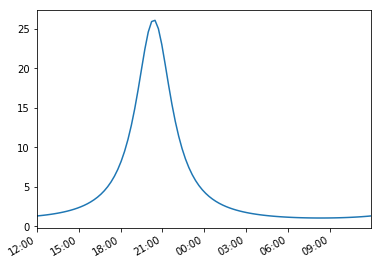

In [12]:
fig, ax = plt.subplots()
ax = plot_airmass(candidateTargets[2:3], CAHA, str(dt.datetime.now().replace(hour=23, minute=59)), brightness_shading=True,
             altitude_yaxis=True, max_airmass=2.25)
ax.legend(facecolor='lightgray')
ax.grid(False, axis='y')
ax.axhspan(2, 3, alpha=.4, facecolor='w', edgecolor='maroon', hatch='//', linestyle='--')
plt.show()

In [ ]:
# fig.savefig('output/airmass.jpg', dpi=300)

visualize long-term (next few months) visibility of candidates

In [39]:
fig, ax = plot_observability(candidateTargets[:1], constraints, CAHA, Time(earliestObs), Time(latestObs))

KeyboardInterrupt: 

In [ ]:
# fig.savefig('output/observability.jpg', dpi=300)

------------------------------